**SNOWFLAKE** is a data-driven approach to interpreting virtual screening results under a set of simple statistical assumptions where the null hypothesis is that there are only inactive molecules in the screen. Upon analysis deviations from the expexted behavior are indicative of likely active molecules. See [this presentation by Paul Hawkins](https://openeye.app.box.com/s/g6kmw8kc3ey1c3uoo3g64d2b131qxgz1) for more details.

**Snowflake Assumptions**

*Null Hypothesis*
> All scores are distributed at random.

This could occur because A) your scoring method is crap, or B) you didnt have any active molecules in your screen.

If the null hypothesis seems to break down, especially at the high end of the score distribution, then perhaps it is time to examine the:

*Alternate Hypothesis*
> there ***may*** be present within this set a small number of actives. If our screening method not crap, these active molecules will tend to have better scores than the inactives.

Lets generate some hypothetical data. We often use bounded scores (e.g. Tanimoto) for VS methods, so we'll generate some hypothetical screening scores below using beta distributions. In this case we'll assume are screening method is successful at separating actives from decoys, but of course there are a much smaller number of actives in the molecules screened than decoys.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context("poster")

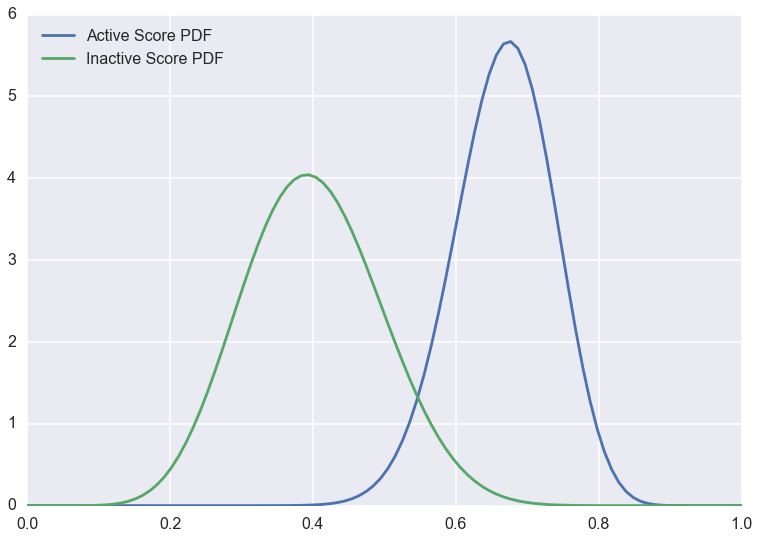

In [2]:
from scipy.stats import beta

# You can adjust these distributions to determine the accuracy of our imaginary screening method
active_dist = beta(30,15)
inactive_dist = beta(10,15)

_ = np.linspace(0,1,100)
plt.plot( _ , active_dist.pdf(_) , label="Active Score PDF")
plt.plot( _ , inactive_dist.pdf(_), label="Inactive Score PDF")
plt.legend(loc="upper left");

Now we'll draw some sample data from these distributions. We'll assume we screened 10000 molecules, of which only 200 were actives.

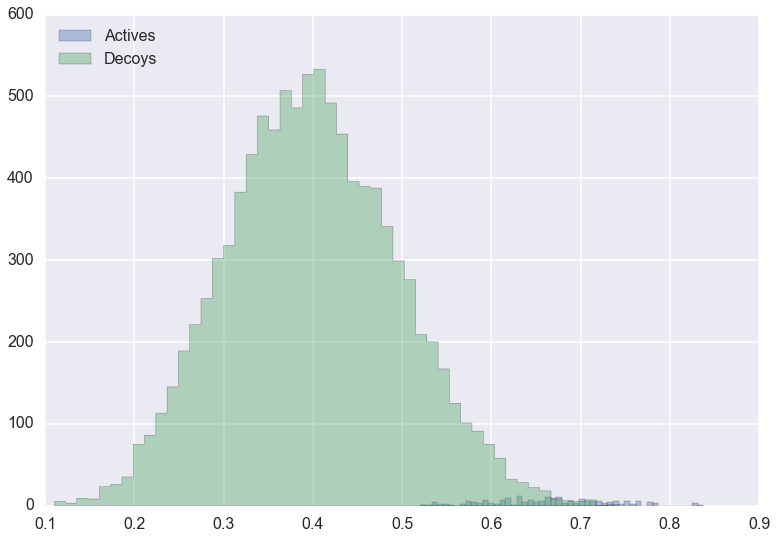

In [3]:
n_inactives = 9800
n_actives = 200
n_screened = n_actives+n_inactives

act_scores = active_dist.rvs(n_actives)
inact_scores = inactive_dist.rvs(n_inactives)

plt.hist(act_scores , bins=50, histtype='bar', alpha=0.4, label="Actives")
plt.hist(inact_scores , bins=50, histtype='stepfilled', alpha=0.4, label="Decoys")
plt.legend(loc="upper left");

Of course in a true VS we don't know the distribution of actives, so all we know is we get a distribution like this:


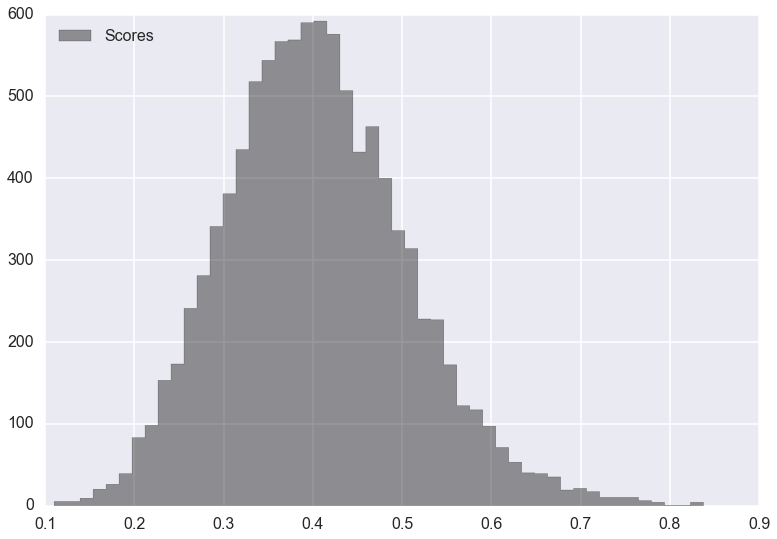

In [4]:
scores = np.concatenate((act_scores, inact_scores))

plt.hist(scores , bins=50, histtype='stepfilled', color='k', alpha=0.4, label="Scores")
plt.legend(loc="upper left");

#### Applying SNOWFLAKE
Now we have our VS scores, a small percentage of which are actives. Now we'll apply **SNOWFLAKE**, but first we'll need to transform our scores. **SNOWFLAKE** assumes a gaussian distribution of scores for inactives, so we'll convert our bounded score to unbounded using the [Logit transform](https://en.wikipedia.org/wiki/Logit).

In [5]:
from scipy.special import logit, expit
from scipy.stats import norm, zscore

tr_scores = logit(scores)

Now we'll fit a gaussian distribution to our scores and assume this is the distribution of inactives. Then we'll compare the Z-scores of the observed scores to the expected normal distribution of scores. We'll assume any deviation from normality on the high end of the scores are due to a small sample of active molecules.

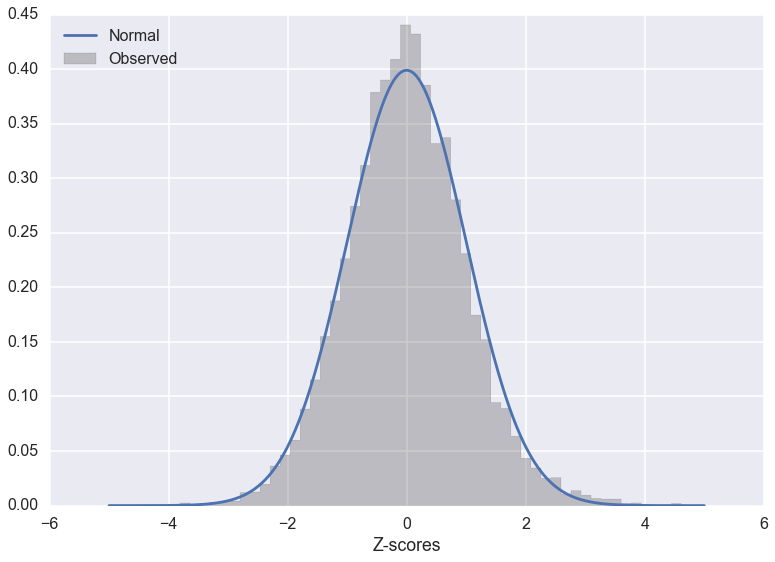

In [6]:
fitmean, fitstd = norm.fit(tr_scores)
zs = np.sort(zscore(tr_scores))

x = np.linspace(-5,5,1000)

plt.plot(x,norm.pdf(x),label="Normal")
plt.hist(zs , bins=50, histtype='stepfilled', normed=True, color='k', alpha=0.2, label="Observed")

plt.xlabel("Z-scores")
plt.legend(loc="upper left");

We determine the **SNOWFLAKE** cutoff as the highest Z-score value where the number of observed scores is higher than the expected distribution.

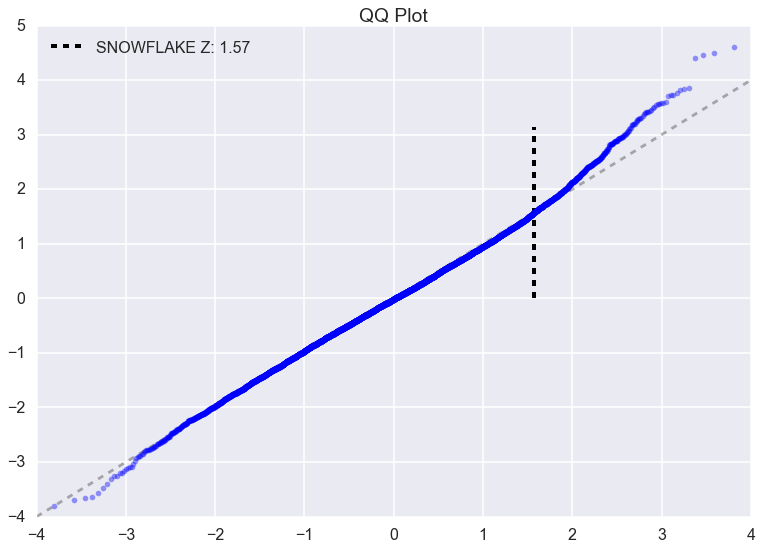

In [7]:
from scipy.stats import probplot
plt.figure()
_ = np.linspace(-4,4)
plt.plot(_,_,'k--',alpha=0.3)

osm, osr = probplot(zs, fit=False, plot=None)
plt.plot(osm, osr, 'b.', alpha=0.4)

diff = osr-osm
stop_pts = np.where(diff < 0.0)[0]
qq_cutoff = osm[stop_pts[-1]]

plt.vlines(qq_cutoff, 0, qq_cutoff*2, linestyles="--", linewidth=4, label="SNOWFLAKE Z: {:.2f}".format(qq_cutoff))
plt.title("QQ Plot")
plt.legend(loc="upper left");

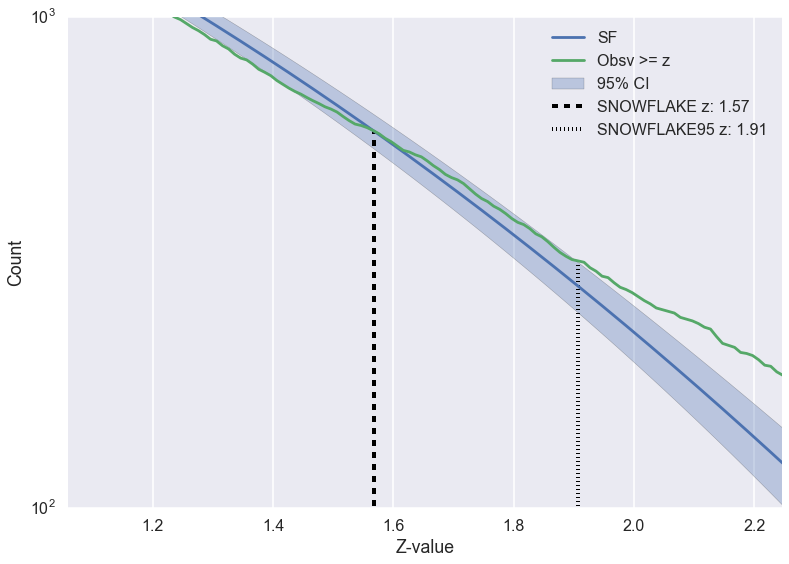

In [8]:
# Determine 95% CI cutoff
obs_count = np.asarray([np.sum(zs >= i) for i in x])
binom_std = np.sqrt(n_screened*norm.sf(x)*(1-norm.sf(x)))

# print(orig_stop, osm[orig_stop], x[orig_stop])
diff = obs_count - (norm.sf(x)*n_screened + 2*binom_std)
x_idx = np.argwhere(x < qq_cutoff)[-1][0]
stop_pts = np.where(diff[x_idx:] > 0.0)[0]
cutoff95 = x[x_idx+stop_pts[0]]



plt.semilogy(x,norm.sf(x)*n_screened, label="SF")
plt.fill_between(x,norm.sf(x)*n_screened - 2*binom_std,
                 norm.sf(x)*n_screened + 2*binom_std, 
                 alpha=0.3, label="95% CI")

plt.semilogy(x,obs_count, label="Obsv >= z")
plt.vlines(qq_cutoff, 1, norm.sf(qq_cutoff)*n_screened, linestyles="--", linewidth=4, label="SNOWFLAKE z: {:.2f}".format(qq_cutoff))
plt.vlines(cutoff95, 1, np.sum(zs >= cutoff95), linestyles=":", linewidth=4, label="SNOWFLAKE95 z: {:.2f}".format(cutoff95))

# plt.xlim(qq_cutoff-0.25, qq_cutoff+0.25)
plt.xlim(qq_cutoff-1.5*(cutoff95-qq_cutoff), qq_cutoff+2*(cutoff95-qq_cutoff))

cut_oom = np.floor(np.log10(norm.sf(qq_cutoff)*n_screened))
plt.ylim(10**(cut_oom),10**(cut_oom+1))

plt.xlabel("Z-value")
plt.ylabel("Count")
plt.legend();


We have the **SNOWFLAKE** Z-cutoff for this virtual screen, the Z-score above which we found more scores than would be expected were this a normally-distributed set of inactive scores. Now we can use the [binomial test](https://en.wikipedia.org/wiki/Binomial_test) to explore the null hypothesis of randomly observing the number of scores above the **SNOWFLAKE** cutoff for a screen of this size.

Finally, we'll convert our snowflake cutoff from a Z-score back to a VS score for use directly with the screening results.

In [9]:
from scipy.stats import binom_test

n_above_cutoff = np.sum(zs >= qq_cutoff)
prob = norm.sf(qq_cutoff)
score_cutoff = expit(qq_cutoff*fitstd+fitmean)
print("SNOWFLAKE cutoff: {:.3f}".format(score_cutoff))
print("Probability of an inactive scoring above SNOWFLAKE: {:.4f}".format(prob))
print("{} scores above the cutoff out of {}".format(n_above_cutoff,len(zs)))
print("p-value of One-sided Binomial Test: {:.4f}".format(binom_test(n_above_cutoff, len(zs), prob, alternative="greater")))

print("\n")
n_above_cutoff = np.sum(zs >= cutoff95)
prob = norm.sf(cutoff95)
score_cutoff95 = expit(cutoff95*fitstd+fitmean)
print("SNOWFLAKE95 cutoff: {:.3f}".format(score_cutoff95))
print("Probability of an inactive scoring above SNOWFLAKE95: {:.4f}".format(prob))
print("{} scores above the 95% cutoff out of {}".format(n_above_cutoff,len(zs)))
print("p-value of One-sided Binomial Test: {:.4f}".format(binom_test(n_above_cutoff, len(zs), prob, alternative="greater")))
print("")



SNOWFLAKE cutoff: 0.572
Probability of an inactive scoring above SNOWFLAKE: 0.0585
584 scores above the cutoff out of 10000
p-value of One-sided Binomial Test: 0.5172


SNOWFLAKE95 cutoff: 0.609
Probability of an inactive scoring above SNOWFLAKE95: 0.0283
318 scores above the 95% cutoff out of 10000
p-value of One-sided Binomial Test: 0.0192



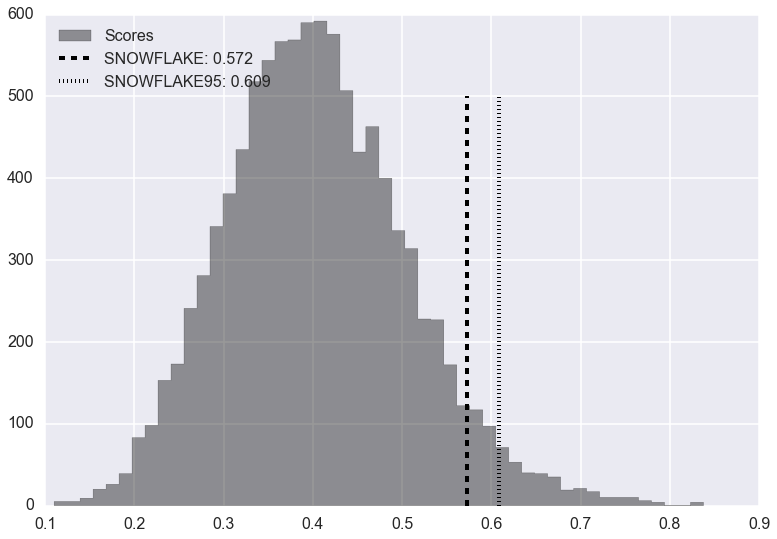

In [10]:
plt.hist(scores , bins=50, histtype='stepfilled', color='k', alpha=0.4, label="Scores")
plt.vlines(score_cutoff, 0, len(scores)*0.05, linestyles="--", linewidth=4, label="SNOWFLAKE: {:.3f}".format(score_cutoff))
plt.vlines(score_cutoff95, 0, len(scores)*0.05, linestyles=":", linewidth=4, label="SNOWFLAKE95: {:.3f}".format(score_cutoff95))

plt.legend(loc="upper left");

If we go back to our hidden knowledge about the scores of actives and decoys, we can see how we the **SNOWFLAKE** cutoff would do at selecting a subset that was enriched with actives:

Actives Selected: 186 of 200
Inactives Selected: 398 of 9800
Actives in Selected Scores 186 of 584     PPV: 0.318


Actives Selected: 161 of 200
Inactives Selected: 157 of 9800
Actives in Selected Scores 161 of 318     PPV: 0.506


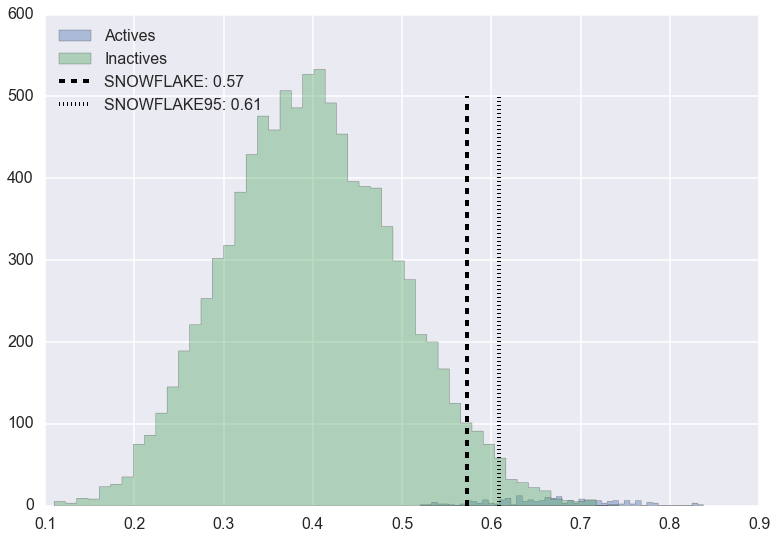

In [11]:
acts_selected = np.sum(act_scores >= score_cutoff)
inacts_selected = np.sum(inact_scores >= score_cutoff)
n_above_cutoff = np.sum(zs >= qq_cutoff)

print("Actives Selected: {} of {}".format(acts_selected, len(act_scores)))
print("Inactives Selected: {} of {}".format(inacts_selected, len(inact_scores)))
print("Actives in Selected Scores {} of {}     PPV: {:.3f}".format(acts_selected, n_above_cutoff,1.*acts_selected/n_above_cutoff))

print("\n")

acts_selected = np.sum(act_scores >= score_cutoff95)
inacts_selected = np.sum(inact_scores >= score_cutoff95)
n_above_cutoff = np.sum(zs >= cutoff95)

print("Actives Selected: {} of {}".format(acts_selected, len(act_scores)))
print("Inactives Selected: {} of {}".format(inacts_selected, len(inact_scores)))
print("Actives in Selected Scores {} of {}     PPV: {:.3f}".format(acts_selected, n_above_cutoff,1.*acts_selected/n_above_cutoff))


plt.hist(act_scores , bins=50, histtype='stepfilled', alpha=0.4, label="Actives")
plt.hist(inact_scores , bins=50, histtype='stepfilled', alpha=0.4, label="Inactives")
plt.vlines(score_cutoff, 0, len(scores)*0.05, linestyles="--", linewidth=4, label="SNOWFLAKE: {:.2f}".format(score_cutoff))
plt.vlines(score_cutoff95, 0, len(scores)*0.05, linestyles=":", linewidth=4, label="SNOWFLAKE95: {:.2f}".format(score_cutoff95))

plt.legend(loc="upper left");

### Snowflake Function
Below we wrap all of snowflake into one function with performs the analysis and optionally generates the plots    

In [12]:
from snowflake import snowflake

In [13]:
snowflake_cutoff, snowflake95_cutoff = snowflake(scores)

SNOWFLAKE cutoff: 0.572
Probability of an inactive scoring above SNOWFLAKE: 0.0585
584 scores above the SNOWFLAKE cutoff out of 10000
p-value of One-sided Binomial Test: 0.5172


SNOWFLAKE95 cutoff: 0.609
Probability of an inactive scoring above SNOWFLAKE95: 0.0283
318 scores above the SNOWFLAKE95 cutoff out of 10000
p-value of One-sided Binomial Test: 0.0192



### Real World Example
We can now apply SNOWFLAKE to real data, in this case a VS from a DUDE validation exercise using ROCS performed on just over 9 million molecules. 

***Loading and working with data of this size may take up to a minute on some systems***

In [14]:
import pandas as pd

big = pd.read_table("/Users/mattg/Downloads/Data_fits/fak1_decoys_default_xray_1.rpt", usecols=['TanimotoCombo'])

SNOWFLAKE cutoff: 0.500
Probability of an inactive scoring above SNOWFLAKE: 0.0001
875 scores above the SNOWFLAKE cutoff out of 9096495
p-value of One-sided Binomial Test: 0.5137


SNOWFLAKE95 cutoff: 0.503
Probability of an inactive scoring above SNOWFLAKE95: 0.0001
747 scores above the SNOWFLAKE95 cutoff out of 9096495
p-value of One-sided Binomial Test: 0.0144



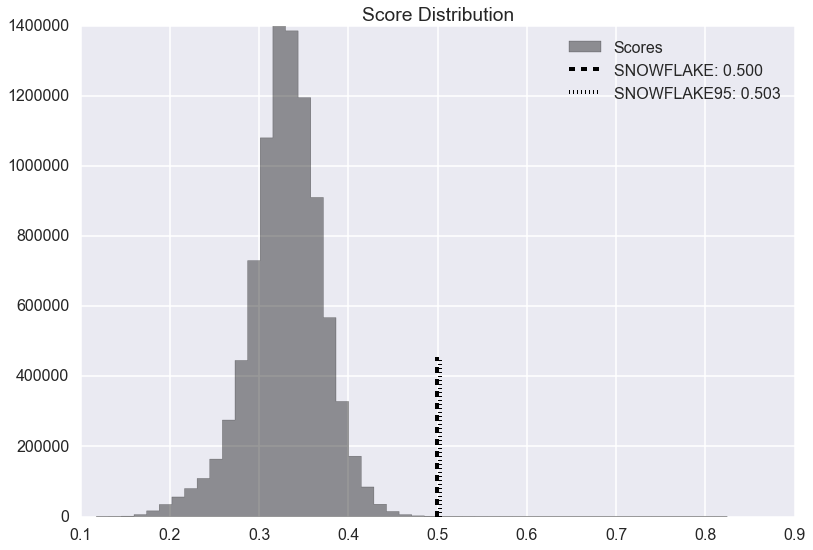

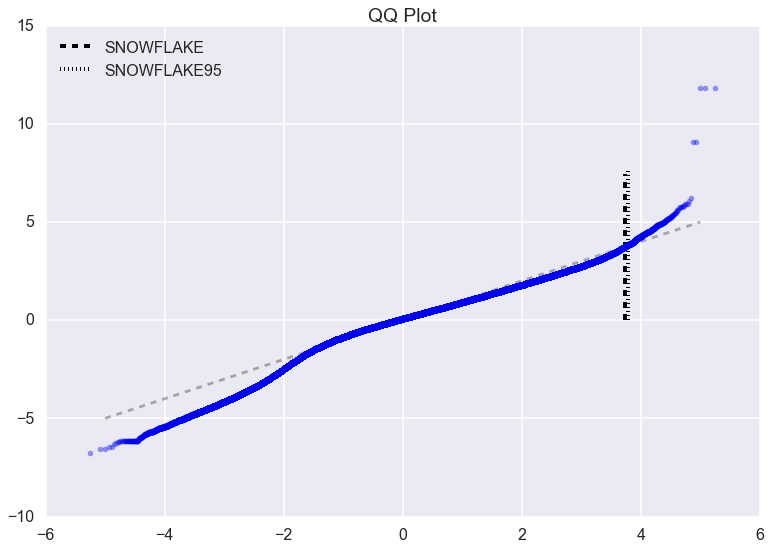

In [15]:
snow_cut, snow95_cut = snowflake(big.TanimotoCombo.values/2., do_plot=True)